In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
echo = pd.read_csv("../merged50Pediatric_ECHO.csv")
manifest = pd.read_csv("../manifest50Pediatric.tsv", sep = '\t')

In [3]:
analysis_type = 'cancerTypeDetailed'

### Clean Up Dataframe

In [4]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

In [5]:
manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'osStatus', 'osMonths']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')

Get a dictionary specific to each patient

In [6]:
# This tracks all genes with ecDNA, separated by _
ecDNA_per_patient = {}
for idx, row in echo.iterrows() :
    if row['patientId'] not in ecDNA_per_patient :
        ecDNA_per_patient[row['patientId']] = ''
    if row['ecDNA_status'] == 'ecDNA' :
        if ecDNA_per_patient[row['patientId']] == '' :
            ecDNA_per_patient[row['patientId']] = row['gene']
        else :
            ecDNA_per_patient[row['patientId']] += '_' + row['gene']

Create dataframe per patient

In [7]:
patientsList = echo['patientId'].unique()

# Tracks ecDNA status and takes the data from above
ecDNA_patient = pd.DataFrame(patientsList, columns = ['patientId'])
ecDNA_patient['ecDNAStatus'] = None
ecDNA_patient['ecDNAList'] = ''

for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient.loc[idx, 'ecDNAList'] = ecDNA_per_patient[row['patientId']]
    if ecDNA_per_patient[row['patientId']] == '' :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = False
    else :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = True


Add copy number (taking the largest copy number)

In [8]:
# Not necessary right now. If you want to use max copy number as a covariate
max_copy_number = {}
for idx, row in echo.iterrows() :
    if row['patientId'] in max_copy_number :
        max_copy_number[row['patientId']] = max(max_copy_number[row['patientId']], row['cn'])
    else :
        max_copy_number[row['patientId']] = row['cn']

ecDNA_patient['max_cn'] = np.nan
for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient.loc[idx, 'max_cn'] = max_copy_number[row['patientId']]


### Basic Plots

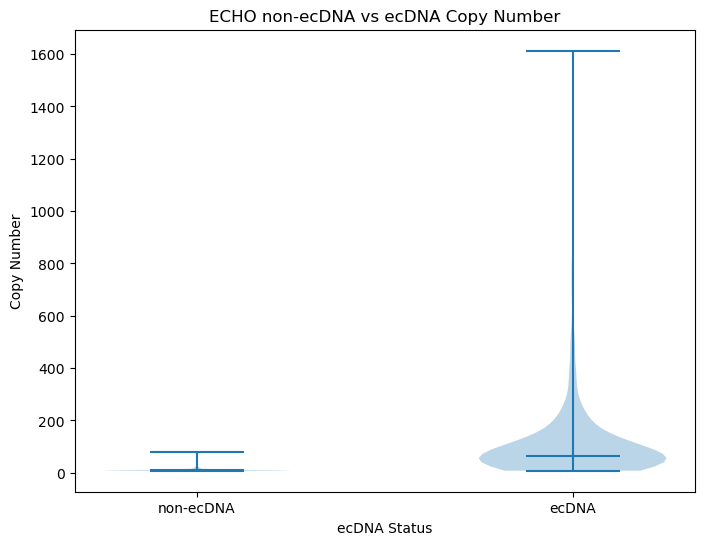

In [9]:
# Plotting violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(dataset=[echo[echo['ecDNA_status'] == 'non-ecDNA']['cn'], 
                        echo[echo['ecDNA_status'] == 'ecDNA']['cn']],
               showmeans=False, showmedians=True)
plt.title('ECHO non-ecDNA vs ecDNA Copy Number')
plt.xticks([1, 2], ['non-ecDNA', 'ecDNA']) 
plt.ylabel('Copy Number')
plt.xlabel("ecDNA Status")
plt.show()

Text(0.5, 1.0, 'ecDNA Probability vs ECHO Copy Number')

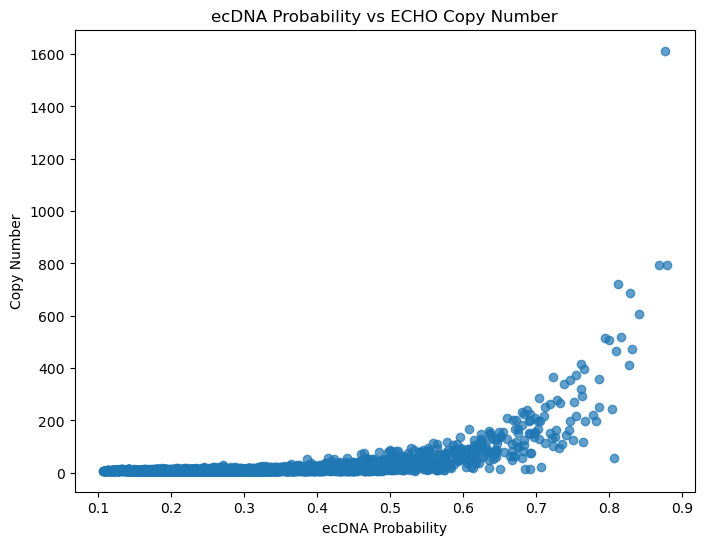

In [114]:
plt.figure(figsize=(8, 6))
plt.scatter(echo['ecDNA_prob'], echo['cn'], alpha=0.7)
plt.ylabel("Copy Number")
plt.xlabel("ecDNA Probability")
plt.title("ecDNA Probability vs ECHO Copy Number")


### cBioPortal Plots

In [11]:
# Add in info from cbioportal
ecDNA_patient['vitalStatus'] = 'NA'
ecDNA_patient['cancerType'] = 'NA'
ecDNA_patient['cancerTypeDetailed'] = 'NA'
ecDNA_patient['osMonths'] = np.nan

# Matches patientIds to indexes
ecDNA_patient_indexes = {}
for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient_indexes[row['patientId']] = idx

# Now the info is right from echo results!
for idx, row in echo.iterrows() :
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'vitalStatus'] = row['osStatus']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerType'] = row['cancerType']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerTypeDetailed'] = row['cancerTypeDetailed']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'osMonths'] = row['osMonths']


### Landscape Graphs

In [12]:
ecDNA_patient_binary = ecDNA_patient[['vitalStatus', 'ecDNAStatus', analysis_type]].astype(str)
ecDNA_patient_binary_filtered = ecDNA_patient_binary[ecDNA_patient_binary['vitalStatus'] != "nan"]
crosstab = pd.crosstab(ecDNA_patient_binary_filtered['vitalStatus'], ecDNA_patient_binary_filtered['ecDNAStatus'])
crosstab

ecDNAStatus,False,True
vitalStatus,,
DECEASED,437,68
LIVING,1188,116


In [13]:
# Change the labels from true/false to ecDNA status
ecDNA_patient_binary_filtered['ecDNAStatus'] = ecDNA_patient_binary_filtered['ecDNAStatus'].replace({'True': 'ecDNA', 'False': 'non-ecDNA'})
ecDNA_patient_binary_filtered['Status'] = ecDNA_patient_binary_filtered['ecDNAStatus'] + " & " + ecDNA_patient_binary_filtered['vitalStatus']

/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_22183/2451063406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecDNA_patient_binary_filtered['ecDNAStatus'] = ecDNA_patient_binary_filtered['ecDNAStatus'].replace({'True': 'ecDNA', 'False': 'non-ecDNA'})
/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_22183/2451063406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecDNA_patient_binary_filtered['Status'] = ecDNA_patient_binary_filtered['ecDNAStatus'] + " & " + ecDNA_patient_bina

In [19]:
crosstab_cancerType = pd.crosstab(ecDNA_patient_binary_filtered[analysis_type], ecDNA_patient_binary_filtered['Status'])
crosstab_cancerType = crosstab_cancerType.loc[crosstab_cancerType.sum(axis = 1) >= 10]
crosstab_cancerType['tempSum'] = crosstab_cancerType[['ecDNA & LIVING', 'ecDNA & DECEASED']].sum(axis=1)
crosstab_cancerType = crosstab_cancerType.sort_values(by = 'tempSum', ascending = False)
crosstab_cancerType.drop(columns=['tempSum'], inplace = True)


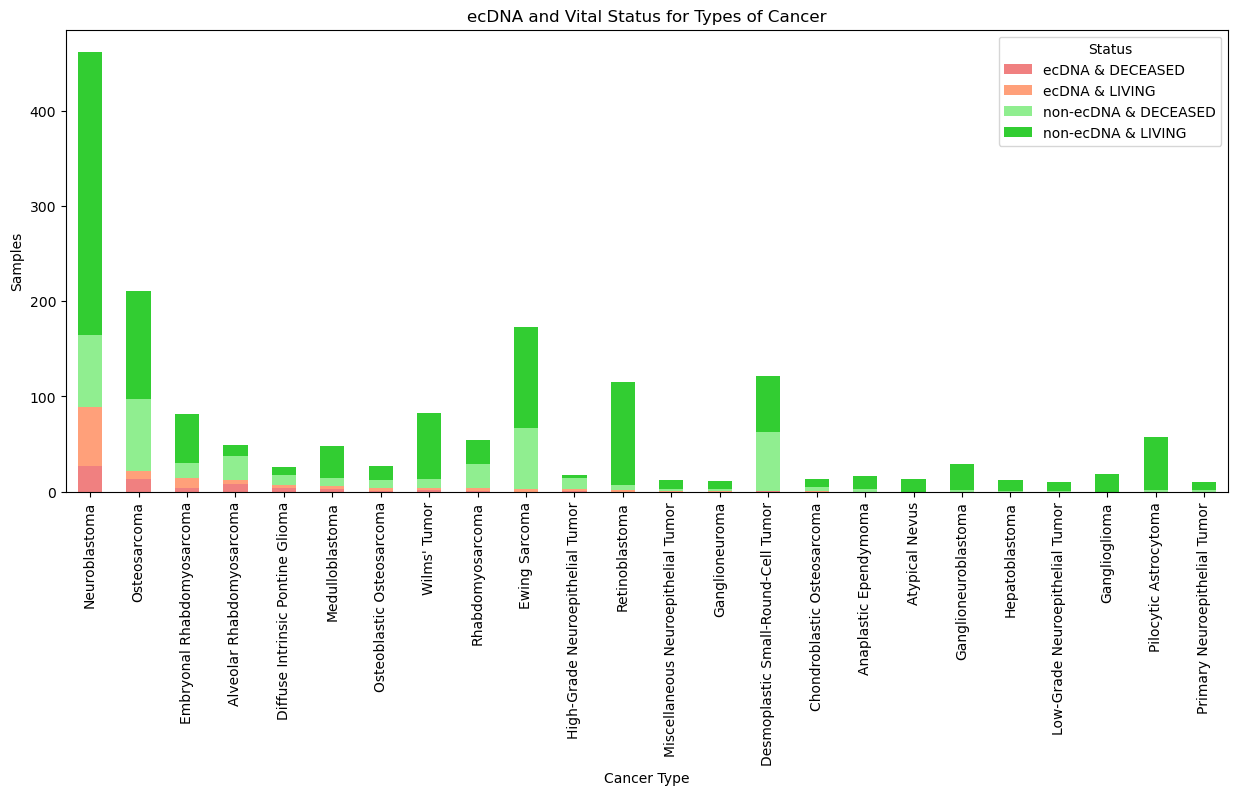

In [20]:
crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['lightcoral', 'lightsalmon', 'lightgreen', 'limegreen'], figsize = (15, 6))
plt.ylabel("Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and Vital Status for Types of Cancer")
plt.show()

In [21]:
normalized_crosstab_cancerType = crosstab_cancerType.div(crosstab_cancerType.sum(axis = 1), axis = 0)
normalized_crosstab_cancerType['tempSum'] = normalized_crosstab_cancerType[['ecDNA & LIVING', 'ecDNA & DECEASED']].sum(axis=1)
normalized_crosstab_cancerType = normalized_crosstab_cancerType.sort_values(by = 'tempSum', ascending = False)
normalized_crosstab_cancerType.drop(columns=['tempSum'], inplace = True) 

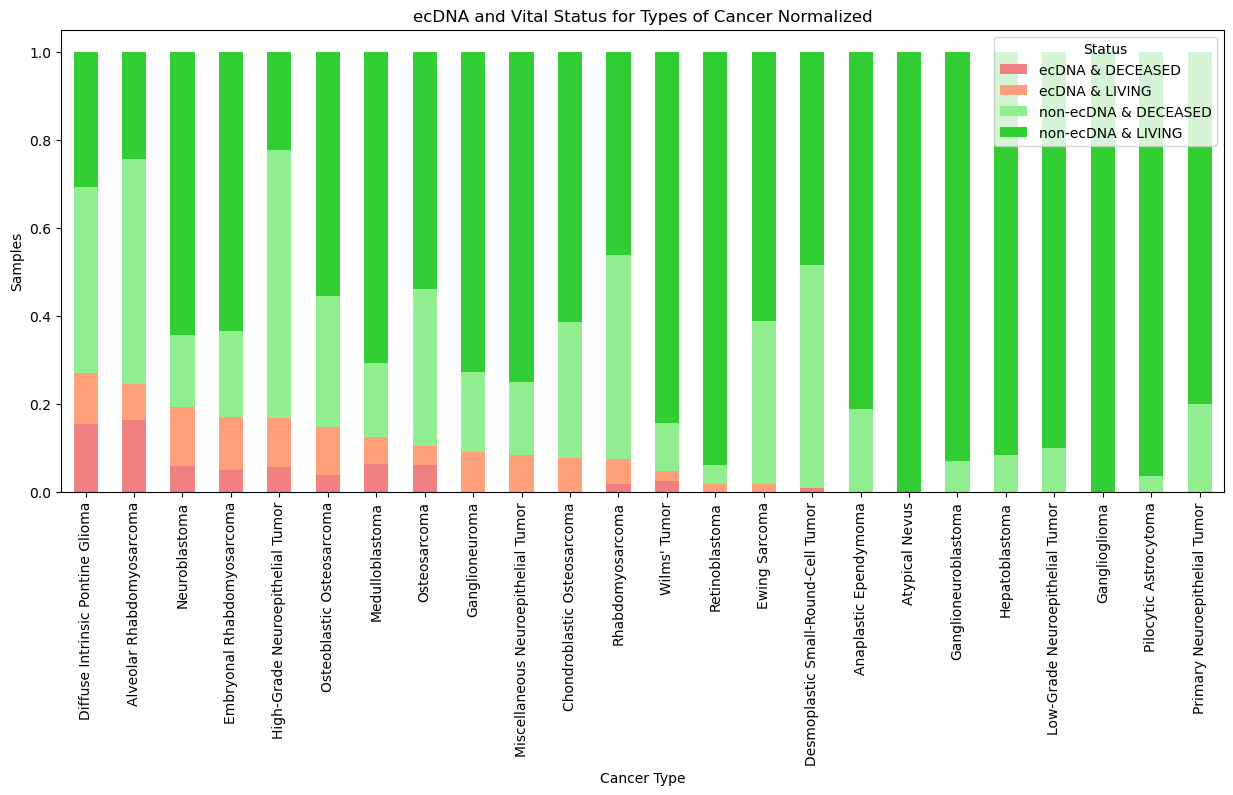

In [22]:
normalized_crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['lightcoral', 'lightsalmon', 'lightgreen', 'limegreen'], figsize=(15,6))
plt.ylabel("Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and Vital Status for Types of Cancer Normalized")
plt.show()

### Survival (OS Months)

/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_22183/3484993211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecDNA_patient_nona['vitalStatus_tf'] = (ecDNA_patient_nona['vitalStatus'] == 'DECEASED').astype(int)
/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_22183/3484993211.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['vitalStatus_tf'] = (subset['vitalStatus'] == 'DECEASED').astype(int)
/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_22183/3484993211.p

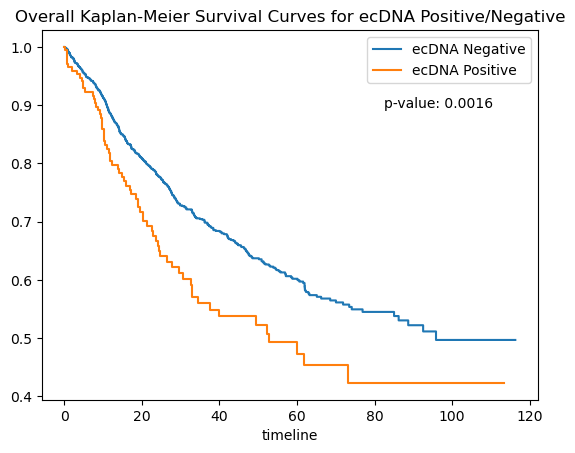

In [44]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths'])
ecDNA_patient_nona['vitalStatus_tf'] = (ecDNA_patient_nona['vitalStatus'] == 'DECEASED').astype(int)

kmf = KaplanMeierFitter()
for status in ecDNA_patient_nona['ecDNAStatus'].unique():
    subset = ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == status]
    kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
    subset['vitalStatus_tf'] = (subset['vitalStatus'] == 'DECEASED').astype(int)

    # labels
    if status == True :
        status = "ecDNA Positive"
    else :
        status = "ecDNA Negative"
    kmf.plot(show_censors=False, ci_show=False, label=f'{status}')

# get p-value
results = logrank_test(ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == True]['osMonths'], 
                           ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == False]['osMonths'],
                           event_observed_A=ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == True]['vitalStatus_tf'], 
                           event_observed_B=ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == False]['vitalStatus_tf'])
plt.text(0.8, 0.8, f'p-value: {results.p_value:.4f}', horizontalalignment='center', 
             verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA Positive/Negative')

plt.legend()

Specific for one cancer type

/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_22183/1911598859.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecDNA_patient_specific['vitalStatus_tf'] = (ecDNA_patient_specific['vitalStatus'] == 'DECEASED').astype(int)
/var/folders/67/9rf7q1w55vx4n2ztp0kqq2xrrx71ry/T/ipykernel_22183/1911598859.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecDNA_patient_specific['vitalStatus_tf'] = (ecDNA_patient_specific['vitalStatus'] == 'DECEASED').astype(int)
/var/folders/67/9rf7q1w55vx4n2ztp0kq

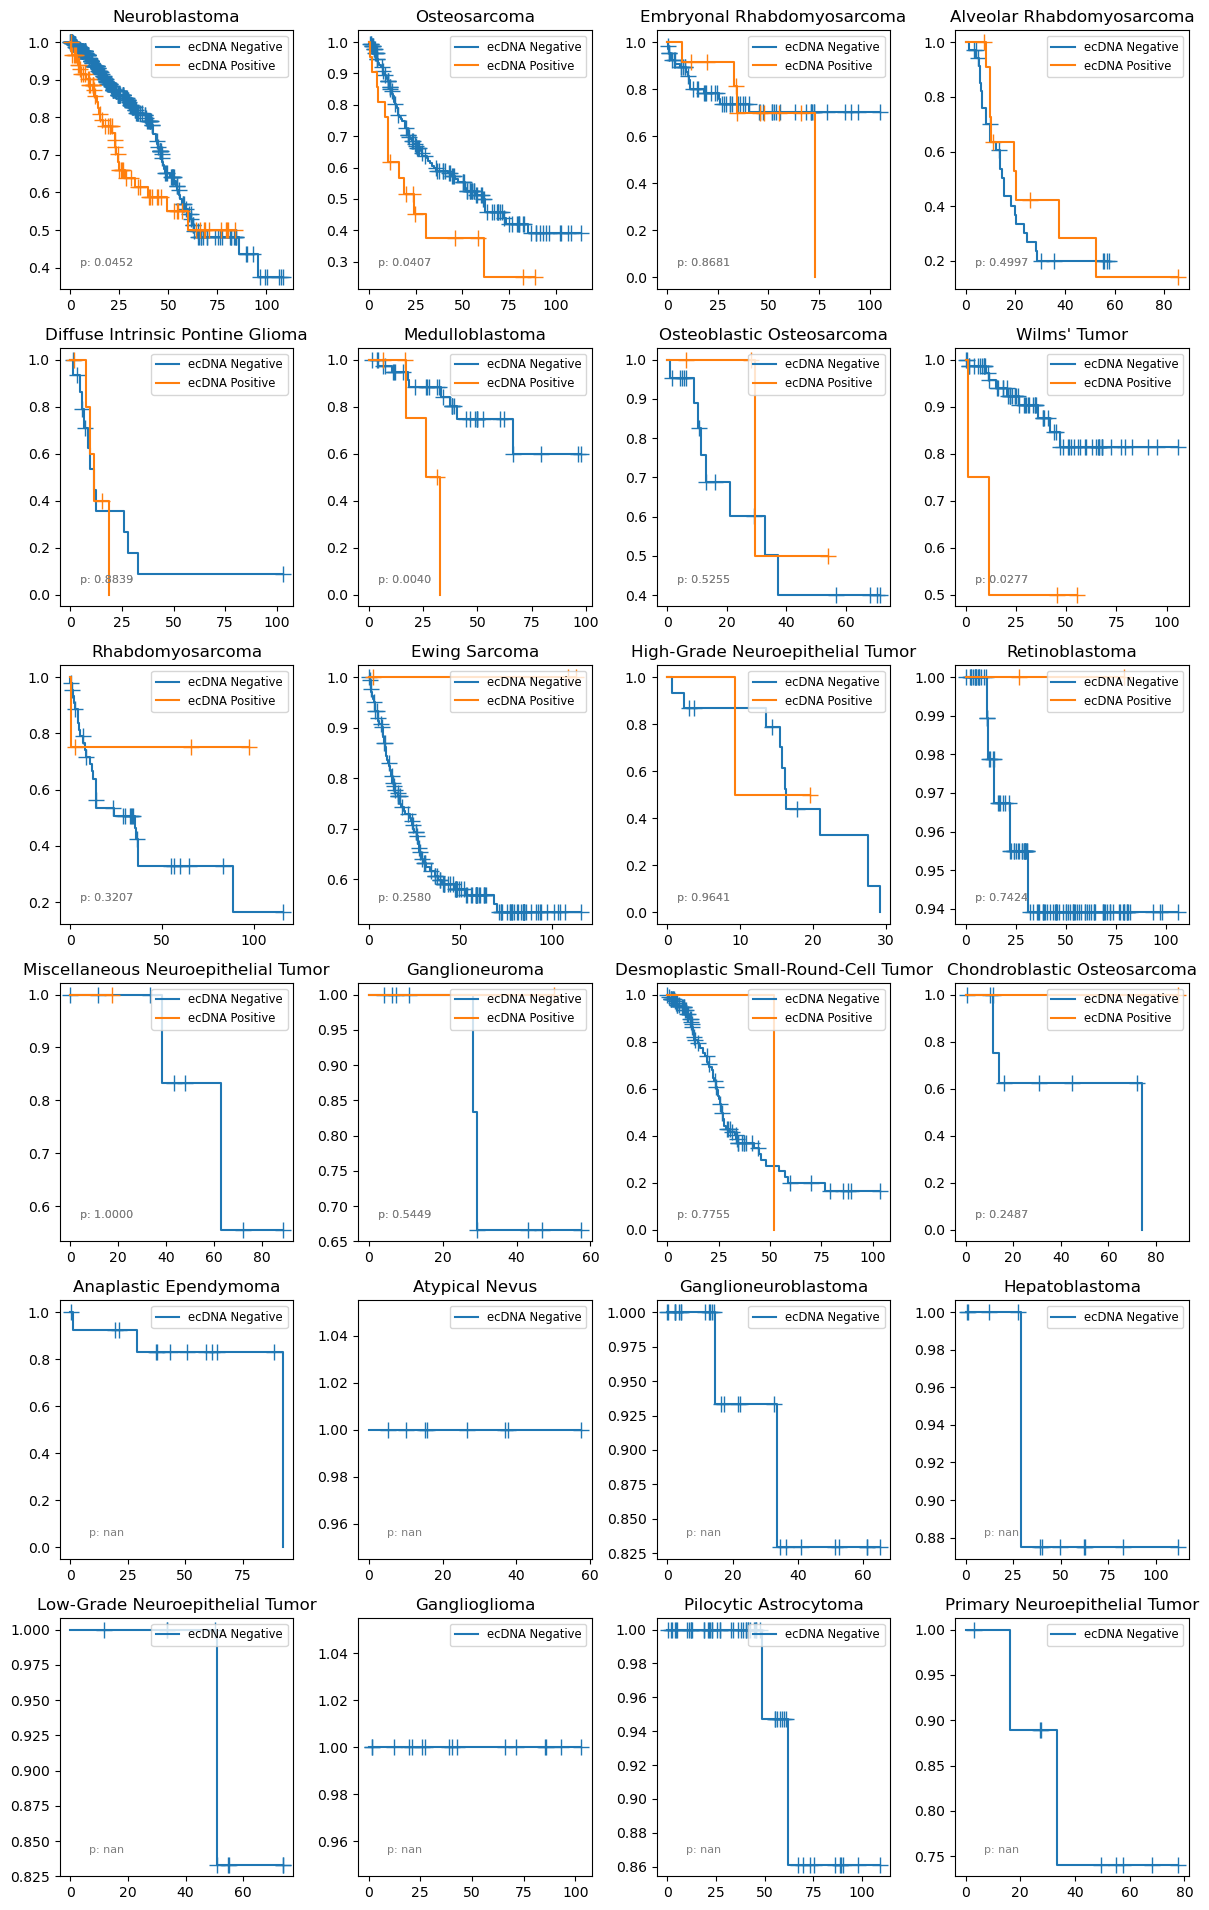

In [64]:

from lifelines import KaplanMeierFitter

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths', analysis_type])
cancer_types = crosstab_cancerType.index.tolist()

# Allow for multiple plots
fig, axs = plt.subplots((len(cancer_types)+3)//4, 4, figsize = (12, 0.8 * len(cancer_types)))
axs = axs.flatten()
for i in range(len(cancer_types)) :
    # Get specific data set for the cancer type
    ecDNA_patient_specific = ecDNA_patient_nona[ecDNA_patient_nona[analysis_type] == cancer_types[i]]
    ecDNA_patient_specific['vitalStatus_tf'] = (ecDNA_patient_specific['vitalStatus'] == 'DECEASED').astype(int)

    for status in sorted(ecDNA_patient_specific['ecDNAStatus'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == status]
        kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
        # labels
        if status == True :
            status = "ecDNA Positive"
        else :
            status = "ecDNA Negative"
        kmf.plot(show_censors=True, ci_show=False, label=f'{status}', ax = axs[i])
        axs[i].legend(loc='upper right', fontsize='small')

        axs[i].set_title(cancer_types[i])
        axs[i].set_xlabel("")
    
        # Get p value
        try :
            results = logrank_test(ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['osMonths'], 
                                    ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['osMonths'],
                                    event_observed_A=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['vitalStatus_tf'], 
                                    event_observed_B=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['vitalStatus_tf'])
            if not results.p_value == np.nan :
                axs[i].text(0.2,0.1, f'p: {results.p_value:.4f}', horizontalalignment='center',
                    verticalalignment='center',
                    transform=axs[i].transAxes,
                    fontsize=8, 
                    color='grey')
        except :
            _ = 5
plt.tight_layout()
plt.show()

### Copy Number as a Covariate

Cox model

In [81]:
ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type])
# Change to 1 or 0
ecDNA_patient_cox['eventOccurred'] = (ecDNA_patient_cox['vitalStatus'] == 'DECEASED').astype(int)

from lifelines import CoxPHFitter

cox = CoxPHFitter()
covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus']
cox.fit(ecDNA_patient_cox[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
print(cox.summary)

                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
ecDNAStatus  0.408881   1.505132  0.130415        0.153271         0.66449   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z  \
covariate                                                                
ecDNAStatus             1.165641             1.943499     0.0  3.13522   

                    p  -log2(p)  
covariate                        
ecDNAStatus  0.001717   9.18568  


In [94]:
import warnings
warnings.filterwarnings("ignore")

ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type])
from lifelines import CoxPHFitter

cox_df = pd.DataFrame(columns = ['ctype', 'p_value', 'hazardRatio', 'upper', 'lower'])

# Create a dataframe for cox model output for each cancer type
for ctype in crosstab_cancerType.index.tolist() :
    try :
        ecDNA_patient_cox_specific = ecDNA_patient_cox[ecDNA_patient_cox[analysis_type] == ctype]
        ecDNA_patient_cox_specific['eventOccurred'] = (ecDNA_patient_cox_specific['vitalStatus'] == 'DECEASED').astype(int)

        cox = CoxPHFitter()
        covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus']
        cox.fit(ecDNA_patient_cox_specific[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
        new_row = {
            'ctype' : ctype,
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)'][0],
            'upper' : cox.summary['exp(coef) upper 95%'][0],
            'lower' : cox.summary['exp(coef) lower 95%'][0]
        }
        new_df = pd.DataFrame([new_row])
        cox_df = pd.concat([cox_df, new_df], ignore_index = True)

    except :
        print(f"{ctype}: Convergence Not Found")

Anaplastic Ependymoma: Convergence Not Found
Atypical Nevus: Convergence Not Found
Ganglioneuroblastoma: Convergence Not Found
Hepatoblastoma: Convergence Not Found
Low-Grade Neuroepithelial Tumor: Convergence Not Found
Ganglioglioma: Convergence Not Found
Pilocytic Astrocytoma: Convergence Not Found
Primary Neuroepithelial Tumor: Convergence Not Found


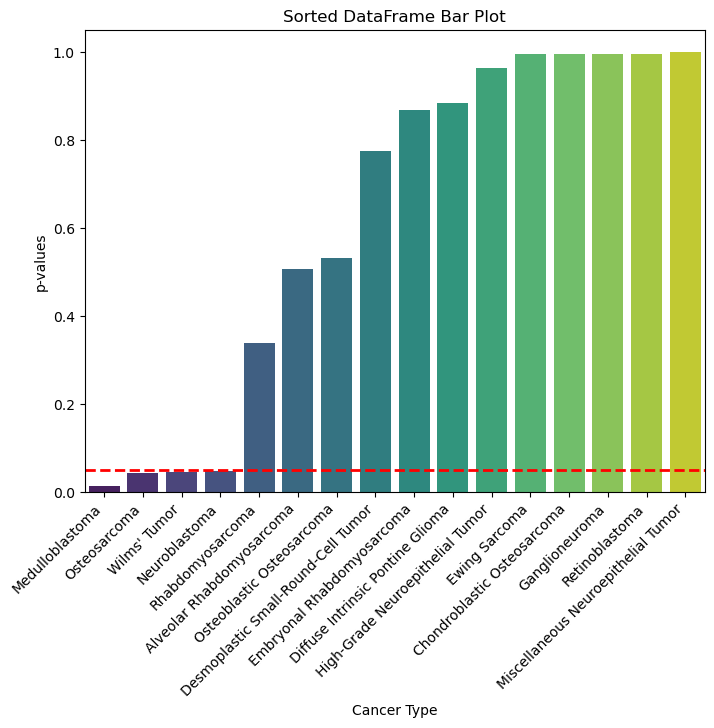

In [99]:
import seaborn as sns

cox_df = cox_df.sort_values(by='p_value')
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='ctype', y='p_value', data=cox_df, palette='viridis')
plt.xlabel('Cancer Type')
plt.ylabel('p-values')
plt.title('Sorted DataFrame Bar Plot')
bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2)

plt.show()

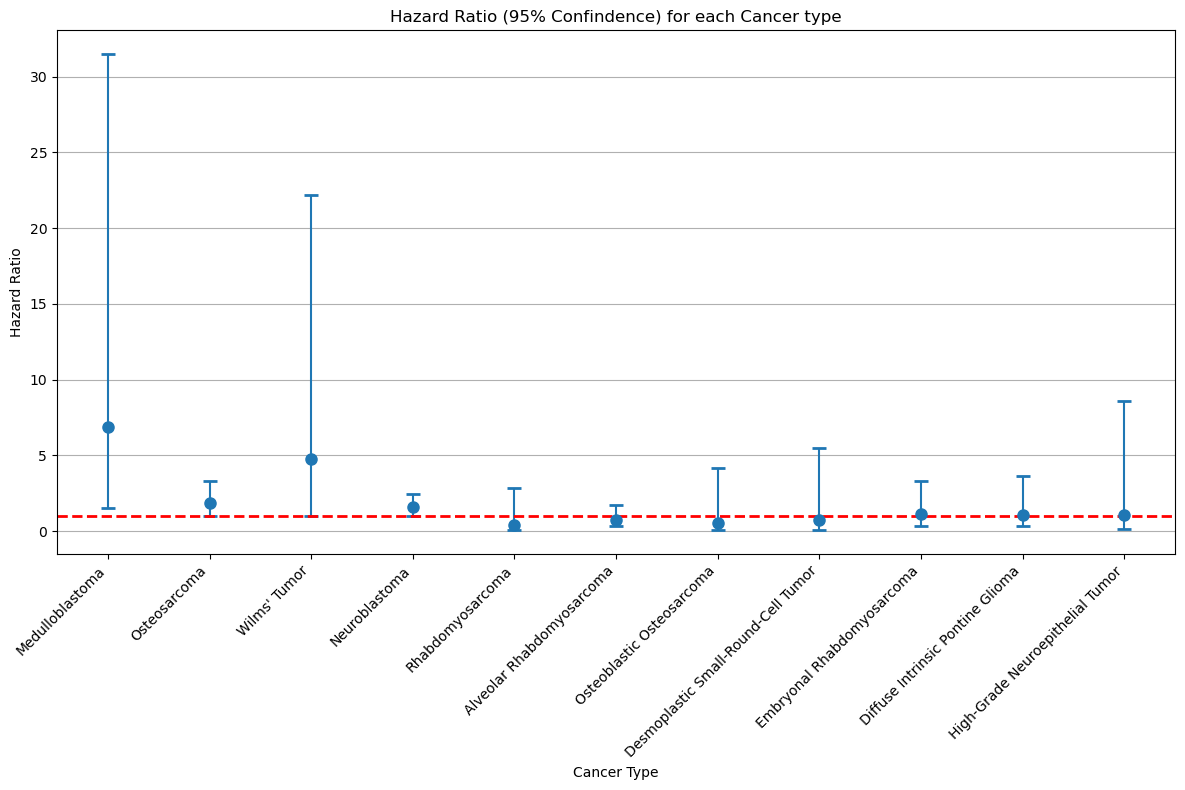

In [113]:
non_zero = cox_df[cox_df['lower'] != 0]

# Number of rows in the DataFrame
num_rows = non_zero.shape[0]

# Plotting points with error bars for each row
plt.figure(figsize=(12, 8))

# Plot points
positions = np.arange(num_rows)
plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
             fmt='o', markersize=8, capsize=5, capthick=2)

# Set x-axis ticks and labels
plt.xlabel('Cancer Type')
plt.xticks(positions, non_zero['ctype'],rotation=45, ha='right')


# Add labels and title
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratio (95% Confindence) for each Cancer type')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2)

plt.grid(True, axis='y')  # Add grid lines for better visualization
plt.tight_layout()
plt.show()

### Gene Level

In [23]:
# Count the number of times each gene is called
gene_called_nonecDNA_count = {}
gene_ecDNA_count = {}

for idx, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['gene'] in gene_ecDNA_count :
            gene_ecDNA_count[row['gene']] += 1
        else :
            gene_ecDNA_count[row['gene']] = 1
    elif row['ecDNA_status'] == 'non-ecDNA' :
        if row['gene'] in gene_called_nonecDNA_count :
            gene_called_nonecDNA_count[row['gene']] += 1
        else :
            gene_called_nonecDNA_count[row['gene']] = 1




Get IMPACT Lists for correction

In [48]:
# These should be in the notebook directory
im3 = pd.read_excel("./IMPACT341-Gene-List_20140101.xlsx")
im3_genes = set(im3['Gene_Symbol'].unique())

im5 = pd.read_excel("./IMPACT410-Gene-List_20150201.xlsx")
im5_genes = set(im5['Gene_Symbol'].unique())

im6 = pd.read_excel("./impact-genes-468.xlsx")
im6_genes = set(im6['Approved Symbol'].unique())

im7 = pd.read_excel("./IMPACT505_Gene_list_detailed.xlsx", header = None)
im7_genes = set()
for column in im7.columns:
    im7_genes.update(im7[column].unique())
im7_genes.remove(np.nan)

/Users/yuk3/miniconda3/envs/ecDNA/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/yuk3/miniconda3/envs/ecDNA/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [79]:
# Count the number of samples in each 
number_im3 = 0
number_im5 = 0
number_im6 = 0
number_im7 = 0

for sample in echo['sampleId'].unique() :
    try :
        if sample[-3:] == "IM3" :
            number_im3 += 1
        elif sample[-3:] == "IM5" :
            number_im5 += 1
        elif sample[-3:] == "IM6" :
            number_im6 += 1
        elif sample[-3:] == "IM7" :
            number_im7+= 1
    except :
        print(f"Warning: {sample}")

print(f"IM3: {number_im3}")
print(f"IM5: {number_im5}")
print(f"IM6: {number_im6}")
print(f"IM7: {number_im7}")

IM3: 38
IM5: 196
IM6: 1018
IM7: 1100


Plot top genes

In [129]:
gene_ecDNA_percentages = {}

for gene in gene_ecDNA_count :
    new_gene = gene
    # These have alternate names that are used
    if new_gene == "NSD3" :
        new_gene = "WHSC1L1"
    if new_gene == "ELOC" :
        new_gene = "TCEB1"
    if new_gene == "H2BC5" :
        new_gene = "HIST1H2BD"
    if new_gene == "ABRAXAS1" :
        new_gene = "FAM175A"
    if new_gene == "MYCL" :
        new_gene = "MYCL1"
    
    # Tally number for each gene
    total_num = 0
    if new_gene in im3_genes :
        total_num += number_im3
    if new_gene in im5_genes :
        total_num += number_im5
    if new_gene in im6_genes :
        total_num += number_im6
    if new_gene in im7_genes :
        total_num += number_im7

    # Default to max number
    if total_num == 0 :
        print(f"{gene} Not Found. Using {number_im3 + number_im5 + number_im6 + number_im7}")
        total_num = number_im3 + number_im5 + number_im6 + number_im7
    gene_ecDNA_percentages[gene] = gene_ecDNA_count[gene]/total_num


EWSR1 Not Found. Using 2352
GTF2I Not Found. Using 2352
PAX8 Not Found. Using 2352
STAT6 Not Found. Using 2352


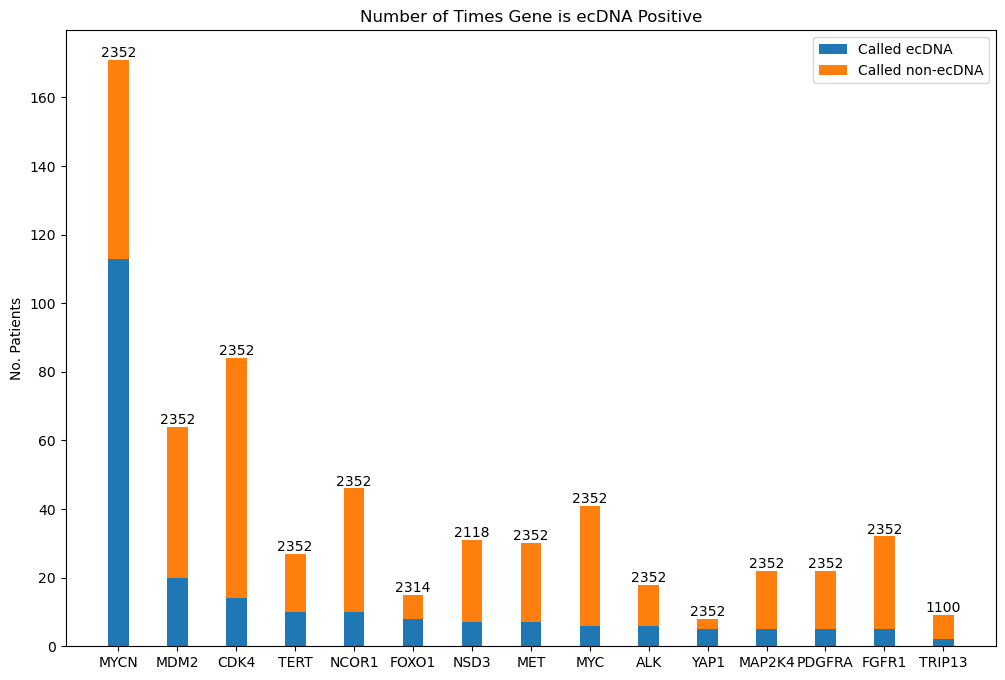

In [133]:
# Pick out top 15 from sorted proportion of ecDNA positive
gene_ecDNA_top15 = dict(sorted(gene_ecDNA_percentages.items(), key=lambda x: x[1], reverse=True)[:15])

keys = gene_ecDNA_top15.keys()
ecDNA_neg = [gene_called_nonecDNA_count[key] for key in keys]
ecDNA_pos = [gene_ecDNA_count[key] for key in keys]

ind = np.arange(len(keys))
width = 0.35

plt.figure(figsize = (12, 8))
p1 = plt.bar(ind, ecDNA_pos, width)
p2 = plt.bar(ind, ecDNA_neg, width, bottom=ecDNA_pos)

for i, value in enumerate(gene_ecDNA_top15) :
    # Change gene names
    if value == "NSD3" :
        value = "WHSC1L1"
    if value == "ELOC" :
        value = "TCEB1"
    if value == "H2BC5" :
        value = "HIST1H2BD"
    if value == "ABRAXAS1" :
        value = "FAM175A"
    if value == "MYCL" :
        value = "MYCL1"

    # Put labels for each which are the number of samples the gene was queried in
    total_num = 0
    if value in im3_genes :
        total_num += number_im3
    if value in im5_genes :
        total_num += number_im5
    if value in im6_genes :
        total_num += number_im6
    if value in im7_genes :
        total_num += number_im7
    plt.text(i, ecDNA_neg[i] + ecDNA_pos[i], str(total_num), ha = 'center', va = 'bottom')

plt.ylabel('No. Patients')
plt.title('Number of Times Gene is ecDNA Positive')
plt.xticks(ind, keys)
plt.legend((p1[0], p2[0]), ('Called ecDNA', 'Called non-ecDNA'))

plt.show()

Which cancers did these genes come from?

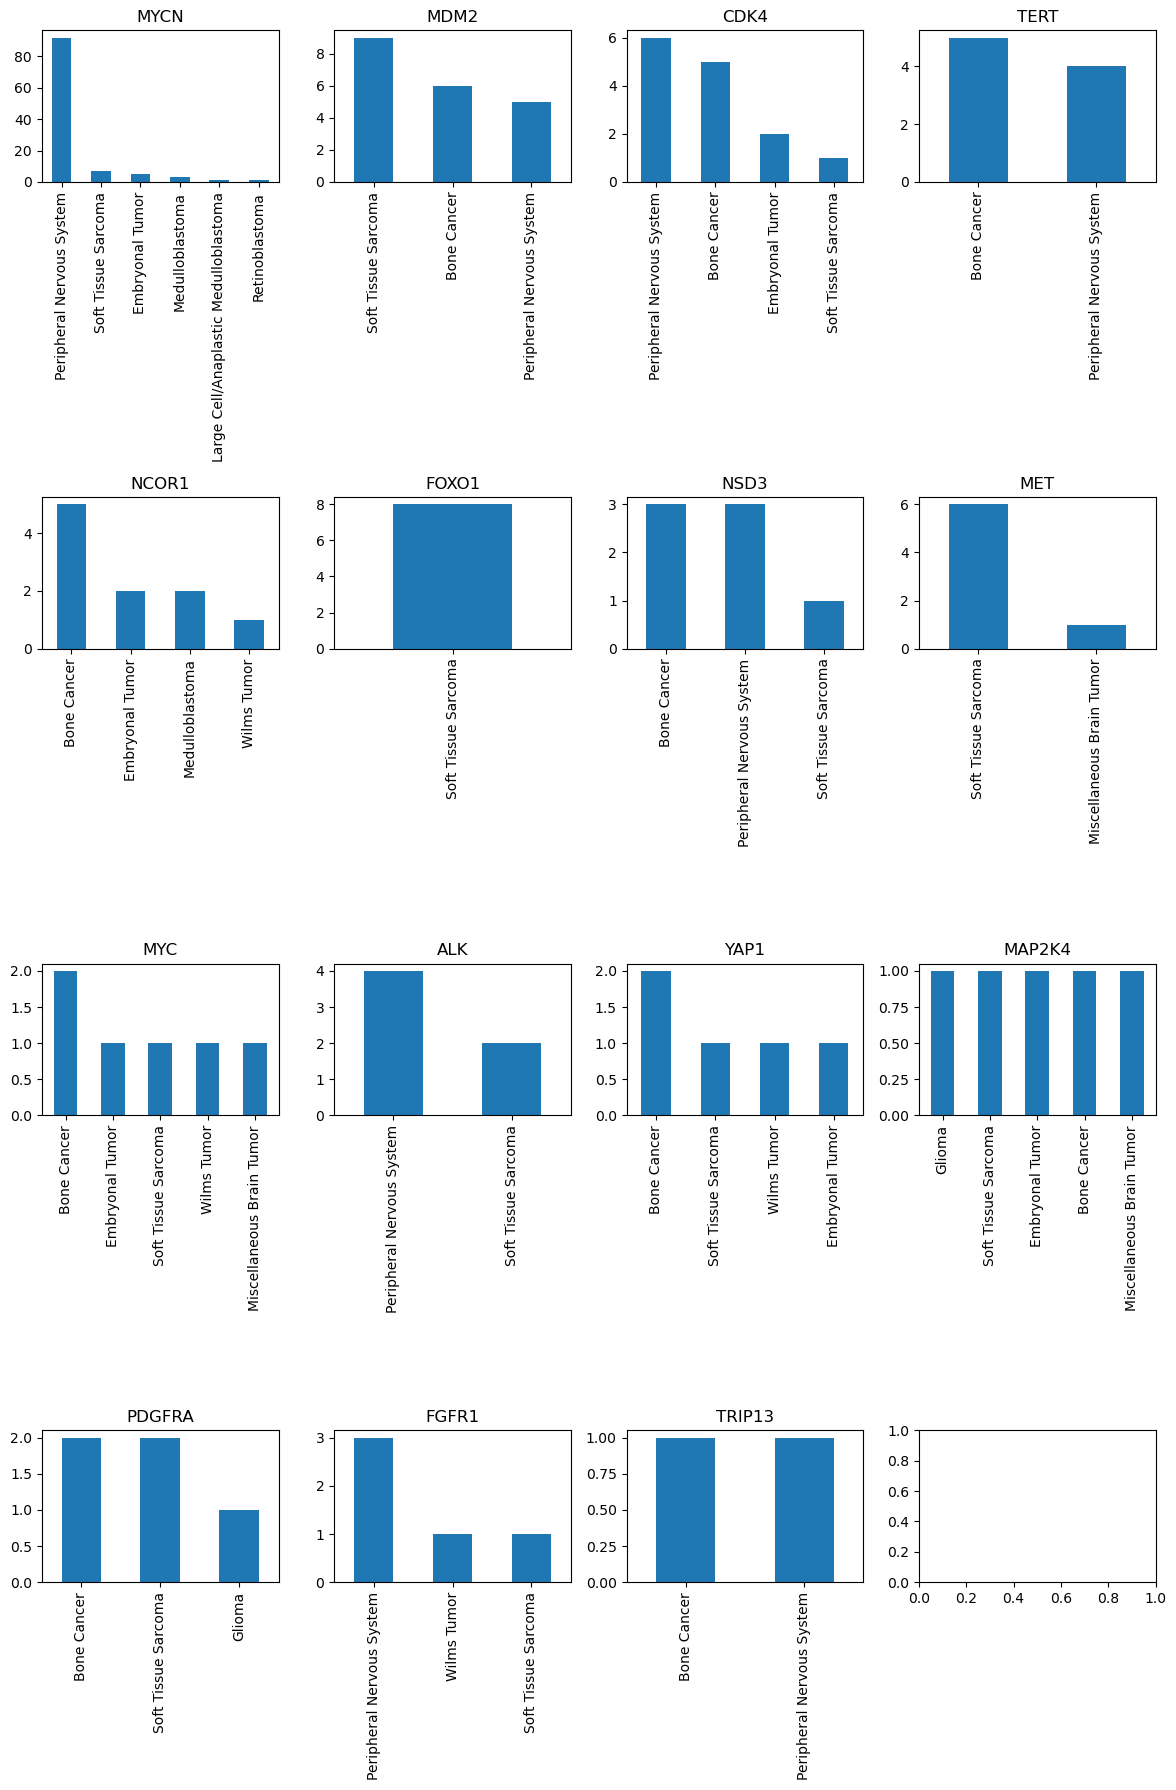

In [134]:
fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset['cancerType'].value_counts()
        counts.plot(kind = 'bar', ax = axs[i])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()



Normalized by counts of each cancer (patient wise)

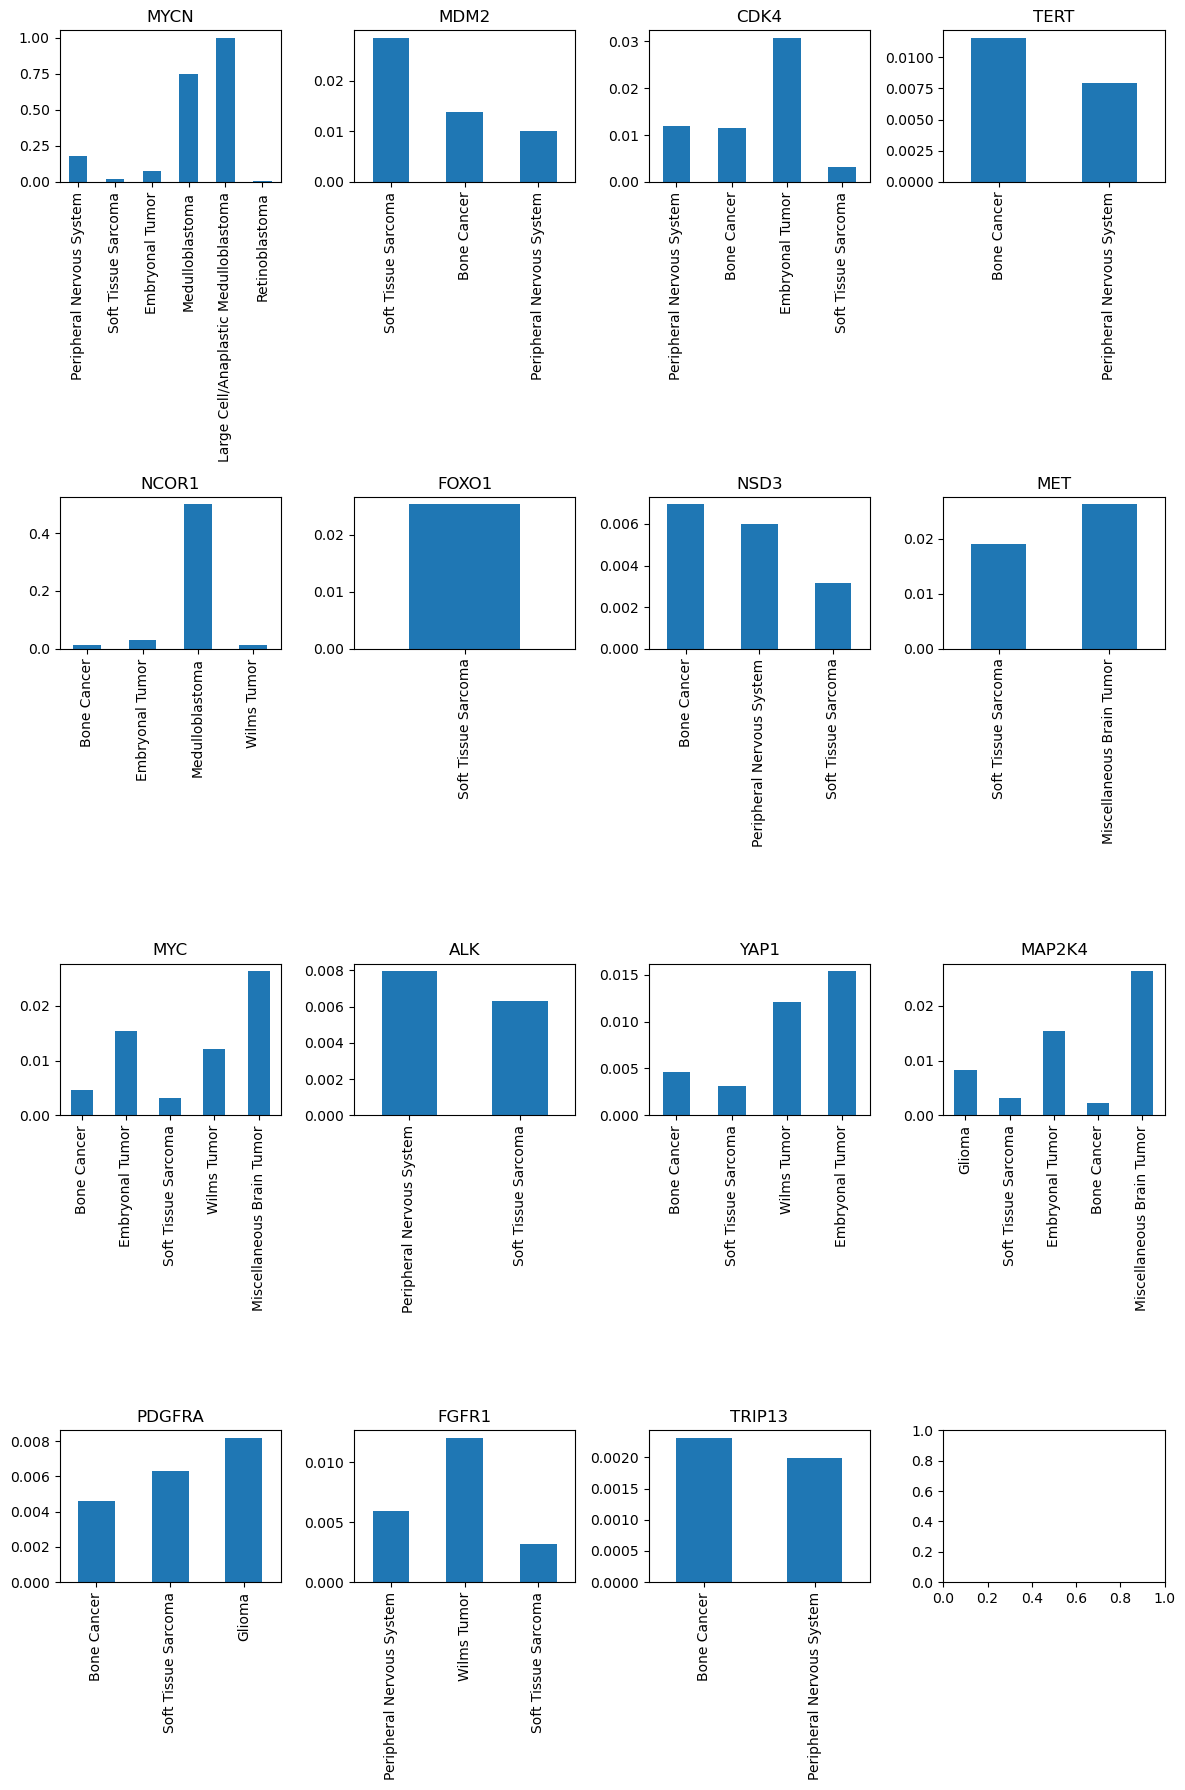

In [135]:
cancerCounts = {}
for i, row in ecDNA_patient.iterrows() :
        if row['cancerType'] in cancerCounts :
                cancerCounts[row['cancerType']] += 1
        else :
                cancerCounts[row['cancerType']] = 1

fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset['cancerType'].value_counts()
        counts = counts / counts.index.map(cancerCounts)
        counts.plot(kind = 'bar', ax = axs[i])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()

